# Question 1

In [ ]:
import math
import numpy
import matplotlib.pyplot as plt

!pip install PySpice

!cat /etc/*release 
!rm libngspice.so*
!rm libngspice.la*
!wget http://www.pcs.cnu.edu/~brash/libngspice.so
!wget http://www.pcs.cnu.edu/~brash/libngspice.la

!rm /usr/local/lib/libngspice.*
!cp /content/libngspice.so /usr/local/lib/libngspice.so.0.0.0
!ln -snf /usr/local/lib/libngspice.so.0.0.0 /usr/local/lib/libngspice.so.0
!ln -snf /usr/local/lib/libngspice.so.0.0.0 /usr/local/lib/libngspice.so
!cp /content/libngspice.la /usr/local/lib/libngspice.la
!ls -al /usr/local/lib
!sudo ldconfig

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Netlist import SubCircuitFactory

2020-12-21 21:21:37,846 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2020-12-21 21:21:37,852 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


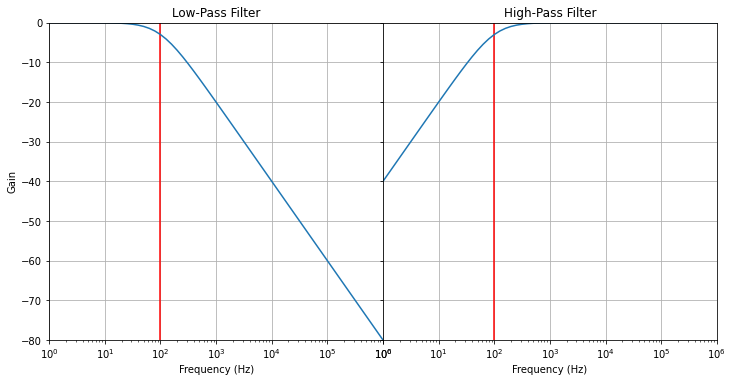

In [9]:
# Low-pass circuit.
lp_circuit = Circuit('Low-Pass')
lp_circuit.SinusoidalVoltageSource('input', 'V_in', lp_circuit.gnd, amplitude=1@u_V)
lp_circuit.R(1, 'V_in', 'R_out', 1.5@u_kΩ)
lp_circuit.C(1, 'R_out', lp_circuit.gnd, 1.061@u_uF)
lp_simulator = lp_circuit.simulator(temperature=25, nominal_temperature=25)
lp_analysis = lp_simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')
lp_gain=20*numpy.log10(numpy.absolute(lp_analysis.R_out))

# High-pass circuit.
hp_circuit = Circuit('High-Pass')
hp_circuit.SinusoidalVoltageSource('input', 'V_in', hp_circuit.gnd, amplitude=1@u_V)
hp_circuit.C(1, 'V_in', 'C_out', 1.061@u_uF)
hp_circuit.R(1, 'C_out', hp_circuit.gnd, 1.5@u_kΩ)
hp_simulator = hp_circuit.simulator(temperature=25, nominal_temperature=25)
hp_analysis = hp_simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')
hp_gain=20*numpy.log10(numpy.absolute(hp_analysis.C_out))

# Plot the results.
fig, axs = plt.subplots(1, 2, figsize=(10,5),sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
axs[0].plot(lp_analysis.frequency, lp_gain)
axs[0].set_xscale('log')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Gain')
axs[0].grid()
axs[0].vlines(x=100, ymin=-80, ymax=0, color='red')
axs[0].margins(0)
axs[0].set_title('Low-Pass Filter')

axs[1].plot(hp_analysis.frequency, hp_gain)
axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].grid()
axs[1].vlines(x=100, ymin=-80, ymax=0, color='red')
axs[1].margins(0)
axs[1].set_title('High-Pass Filter')

plt.show()

2020-12-21 21:21:41,004 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less


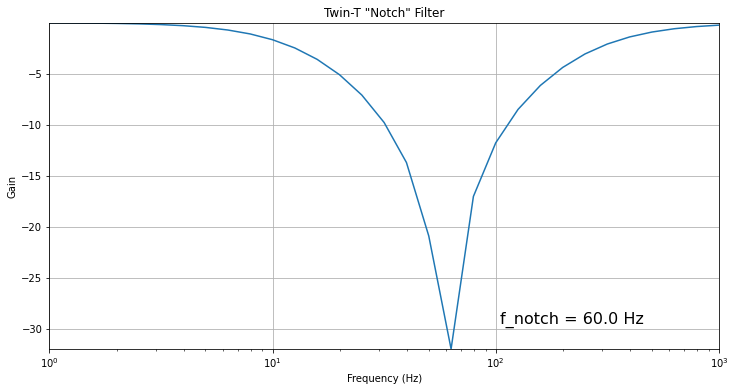

In [10]:
# Define values to create the 60 Hz notch.
R = 250@u_Ω
C = 10.6105@u_uF
f_notch = 'f_notch = ' + str(round(1 / (2 * numpy.pi * R * C), 2)) + ' Hz'

# Create circuit.
notch_circuit = Circuit('Twin-T Notch')
notch_circuit.SinusoidalVoltageSource('input', 'V_in', notch_circuit.gnd, amplitude=1@u_V)
notch_circuit.C(1, 'V_in', 'C_1_out', C)
notch_circuit.C(2, 'C_1_out', 'V_out', C)
notch_circuit.R(1, 'V_in', 'R_1_out', R)
notch_circuit.R(2, 'R_1_out', 'V_out', R)
notch_circuit.C(3, 'R_1_out', notch_circuit.gnd, 2 * C)
notch_circuit.R(3, 'C_1_out', notch_circuit.gnd, R / 2)
notch_simulator = notch_circuit.simulator(temperature=25, nominal_temperature=25)
notch_analysis = notch_simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_kHz, number_of_points=10,  variation='dec')
notch_gain=20*numpy.log10(numpy.absolute(notch_analysis.V_out))

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(notch_analysis.frequency, notch_gain)
plt.xscale('log')
plt.title('Twin-T "Notch" Filter')
plt.text(105, -29.5, f_notch, fontsize=16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.margins(0)
plt.grid()
plt.show()

# Question 2

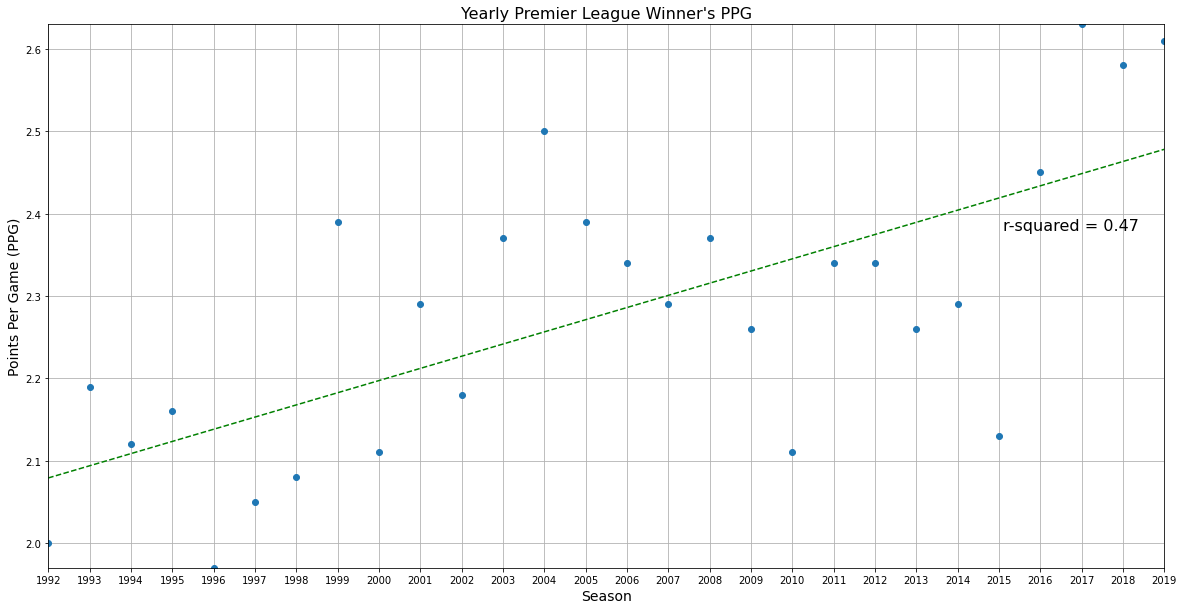

In [6]:
import numpy
import re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import Request
from scipy.optimize import curve_fit

def linearfit(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

url = Request('https://www.myfootballfacts.com/premier-league-winners/', headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(url)
html = webpage.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

test = soup.find('table', attrs={"class": "filterable"})
years = []
ppg = []
for i in numpy.arange(1, 29):
    year_col = str(soup.find("td", attrs={"class": "dtr" + str(i) + " dtc0"})) 
    years.append(int(re.split('<|>', year_col)[6].split('-')[0]))
    ppg_col = str(soup.find("td", attrs={"class": "dtr" + str(i) + " dtc11"}))
    ppg.append(float(re.split('<|>', ppg_col)[2]))

df = pd.DataFrame({'Year':years, 'PPG':ppg})

p0 = numpy.array([0, 0])
popt, pcov = curve_fit(linearfit, df["Year"], df['PPG'], p0)

residuals = df['PPG'] - linearfit(df["Year"], *popt)
sum_squares_res = numpy.sum(residuals**2)
sum_squares_tot = numpy.sum((df['PPG'] - numpy.mean(df['PPG']))**2)
r_squared = 1 - (sum_squares_res / sum_squares_tot)

plt.figure(figsize=(20,10))
plt.plot(df["Year"], df['PPG'], 'o')
plt.plot(df["Year"], linearfit(df["Year"], *popt), 'g--')
plt.xticks(numpy.arange(1992, 2021))
plt.margins(0)
plt.grid()
plt.title("Yearly Premier League Winner's PPG", fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Points Per Game (PPG)', fontsize=14)
plt.text(2015.1, 2.38, "r-squared = " + str(round(r_squared, 2)), fontsize=16)
plt.show()

# Question 3

In [1]:
"""
=================
Ideal gas simulation
=================
Ideal gas simulation in a 3D system at temperature T and volume L^3,
where L is the length of the walls.
The particles that form the system only interact with the walls and 
between each other with elastic collisions, no other type of
interaction is considered (electromagnetic, gravitational...)
"""
from __future__ import division, print_function
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import types

In [2]:
k_B = 1.380648e-23  # boltzmann contant (J/K)

def mod(v):
    """
        computes the squared sum over the last axis of the numpy.ndarray v
    """
    return numpy.sum(v * v, axis=-1)

def pmod(v, T, m):
    """
        Maxwell-Boltzmann's distribuion of probability 
        for the length of the velocity vector v at temprature T
        for a particle of mass m
    """
    return 4 * numpy.pi * v**2 * numpy.power(m / (2 * numpy.pi * k_B * T), 3 / 2) * numpy.exp(- m * v**2 / (2 * k_B * T))


class Simulation(animation.TimedAnimation):
    """
        Complete code for the ideal gas animation.
    """

    def __init__(self, n_particles, mass, rad, T, V, max_time, dt=0.2):
        """
            Initiallisation of parameters
            ::n_particles:: number of particles in the system
            ::mass:: of the particles (identicle for all of them)
            ::rad:: radius of the particles, notice that it must be
                    of the same order as (V/n_particles)^(1/3) in
                    order to see them colliding. If the radius is too
                    small then too few collisions would occur.
                    To remove completely the number of cillisions set the
                    radius to 0.
            ::T:: temperature of the system, this will define the initial
                    velocity of the particles
            ::V:: volume of the system, this could be a floating-point number or 
                    a function of time. If it is a number then the volume will
                    remain constant all the time, if it is a function then at each
                    iteration the volume will be update over time.
            ::max_time:: maximum animation time
        """
        
        print ("-------------------")
        print (n_particles,mass,rad,T,V,max_time,dt)
        print ("-------------------")

        self.PART = n_particles
        self.MASS = mass
        self.RAD = rad
        self.DIAM = 2 * rad

        self.T = T

        if isinstance(V, types.FunctionType):
            self.V0 = V(0)
            self.V = V
            self.Vconst = False
        else:
            self.V0 = V
            self.V = lambda t: V
            self.Vconst = True

        self.L = numpy.power(self.V0, 1/3) # side length
        self.halfL = self.L / 2
        self.A = 6 * self.L**2 # total surface area

        self.max_time = max_time
        self.dt = dt
        self.Nt = int(max_time / self.dt)

        self.evaluate_properties()

        # velocities histogram
        self.min_v = 0
        self.max_v = self.vmax * 3
        self.dv = 0.2 # (m/s)
        self.Nv = int((self.max_v - self.min_v) / self.dv)

        # pressure
        self.dP = 1 # (s)
        self.NP = int(max_time / self.dP)

        self.init_particles()
        self.init_figures()

        animation.TimedAnimation.__init__(self, self.fig, interval=1, blit=True, repeat=False)

    def evaluate_properties(self):
        """
            Calculates the initial properties of the system according
            to the laws of thermodynamics.
        """

        self.P = self.PART * k_B * self.T / self.V0
        self.U = 1.5 * self.PART * k_B * self.T
        self.vrms = numpy.sqrt(3 * k_B * self.T / self.MASS)
        self.vmax = numpy.sqrt(2 * k_B * self.T / self.MASS)
        self.vmed = numpy.sqrt(8 * k_B * self.T / (numpy.pi * self.MASS))

    def init_particles(self):
        """
            Initialize the particles positions and velocities.
            The initial positions are completely random inside the box.
            The initial velocities are generated by a random unitary vector with
            a length given by the average velocity (vmed) at the system temperature. 
        """
        self.r = numpy.random.rand(self.PART, 3) * 2.0 * (self.halfL - self.RAD) -(self.halfL - self.RAD)

        v_polar = numpy.random.random((self.PART, 2))

        self.v = numpy.zeros((self.PART, 3))

        self.v[:,0] = numpy.sin(v_polar[:,0] * numpy.pi) * numpy.cos(v_polar[:,1] * 2 * numpy.pi)
        self.v[:,1] = numpy.sin(v_polar[:,0] * numpy.pi) * numpy.sin(v_polar[:,1] * 2 * numpy.pi)
        self.v[:,2] = numpy.cos(v_polar[:,0] * numpy.pi)

        self.v *= self.vrms

    def init_figures(self):
        """
            Init the figures, axes, lines...
        """

        self.fig = plt.figure(figsize=(4,12))

        self.ax1 = plt.subplot2grid((3, 1), (0, 0), projection='3d') # 3D axes
        self.ax2 = plt.subplot2grid((3, 1), (2, 0)) # x-y axes
        self.ax3 = plt.subplot2grid((3, 1), (2, 0)) # y-z axes
        self.ax4 = plt.subplot2grid((3, 1), (2, 0)) # x-z axes
        self.ax5 = plt.subplot2grid((3, 1), (1, 0)) # velocities axes
        self.ax6 = plt.subplot2grid((3, 1), (2, 0)) # pressure axes

        # Setup ax1: 3d
        box_limits = [-self.halfL, self.halfL]
        self.ax1.set_xlim3d(box_limits)
        self.ax1.set_xlabel('X')

        self.ax1.set_ylim3d(box_limits)
        self.ax1.set_ylabel('Y')

        self.ax1.set_zlim3d(box_limits)
        self.ax1.set_zlabel('Z')

        self.line_3d = self.ax1.plot([], [], [], ls='None', marker='.')[0]
        self.line_3d_cm = self.ax1.plot([0], [0], [0], ls='None', marker='.', color='r')[0]

        # setup ax2: x-y
        self.ax2.set_xlabel(r'x')
        self.ax2.set_ylabel(r'y')
        self.ax2.set_xlim(box_limits)
        self.ax2.set_ylim(box_limits)

        self.line_xy = self.ax2.plot([], [], ls='None', marker='.')[0]
        self.line_xy_cm = self.ax2.plot([0], [0], ls='None', marker='.', color='r')[0]

        # setup ax3: y-z
        self.ax3.set_xlabel(r'y')
        self.ax3.set_ylabel(r'z')
        self.ax3.set_xlim(box_limits)
        self.ax3.set_ylim(box_limits)

        self.line_yz = self.ax3.plot([], [], ls='None', marker='.')[0]
        self.line_yz_cm = self.ax3.plot([0], [0], ls='None', marker='.', color='r')[0]

        # setup ax4: x-z
        self.ax4.set_xlabel(r'x')
        self.ax4.set_ylabel(r'z')
        self.ax4.set_xlim(box_limits)
        self.ax4.set_ylim(box_limits)

        self.line_xz = self.ax4.plot([], [], ls='None', marker='.')[0]
        self.line_xz_cm = self.ax4.plot([0], [0], ls='None', marker='.', color='r')[0]

        # setup ax5: velocities
        vs = numpy.linspace(0, self.vmax * 3, 100)
        self.ax5.set_xlabel(r'$v\ (m/s)$')
        self.ax5.set_ylabel(r'$N$')
        #ax5.set_ylim(0, numpy.ceil(self.PART * pmod(self.vmax, self.T, self.MASS) / 5))
        self.ax5.plot(vs, self.PART * pmod(vs, self.T, self.MASS) * self.dv, color='r')

        self.vel_x = numpy.linspace(self.min_v, self.max_v, self.Nv)
        self.vel_y = numpy.zeros(self.Nv)

        self.line_vel = self.ax5.plot([], [], color='b', lw=0.5)[0]

        # setup ax6: pressure
        self.ax6.set_xlabel(r'$V\ (m^3)$')
        self.ax6.set_ylabel(r'$P\ (Pa)$')
        if self.Vconst:
            pt = self.PART * k_B * self.T / self.V0
            self.ax6.plot([0,self.max_time], [pt, pt], color='r', lw=0.5)
        else:
            Vx = self.V(numpy.linspace(0, self.max_time, self.Nt))
            self.ax6.plot(Vx, self.PART * k_B * self.T / Vx, color='r', lw=0.5)

        self.ex_p = 0.0 # accumulated exchanged momentum with the walls
        self.last_P = -1
        self.P_x = numpy.zeros(self.NP)
        self.P_y = numpy.zeros(self.NP)

        self.line_p = self.ax6.plot([], [], color='b', lw=0.5)[0]

        self._drawn_artists = [self.line_3d, self.line_3d_cm, 
                 self.line_xy, self.line_xy_cm,
                 self.line_yz, self.line_yz_cm,
                 self.line_xz, self.line_xz_cm,
                 self.line_vel, self.line_p]

    def update_volume(self, t):
        """
            Sets the new volume and changes the axes limits.
        """

        self.V0 = self.V(t)
        self.L = numpy.power(self.V0, 1/3)
        self.halfL = self.L / 2
        self.A = 6 * self.L**2

        box_limits = [-self.halfL, self.halfL]
        self.ax1.set_xlim3d(box_limits)
        self.ax1.set_ylim3d(box_limits)
        self.ax1.set_zlim3d(box_limits)
        self.ax2.set_xlim(box_limits)
        self.ax2.set_ylim(box_limits)
        self.ax3.set_xlim(box_limits)
        self.ax3.set_ylim(box_limits)
        self.ax4.set_xlim(box_limits)
        self.ax4.set_ylim(box_limits)

    def _draw_frame(self, t):
        self.update_volume(t)

        # update the position
        self.r += self.dt * self.v

        # check for collisions with other particles
        dists = numpy.sqrt(mod(self.r - self.r[:,numpy.newaxis]))
        cols2 = (0 < dists) & (dists < self.DIAM)
        idx_i, idx_j = numpy.nonzero(cols2)
        # ***possibility to simplify this *** #
        for i, j in zip(idx_i, idx_j):
            if j < i:
                # skip duplications and same particle
                continue 

            rij = self.r[i] - self.r[j]
            d = mod(rij)
            vij = self.v[i] - self.v[j]
            dv = numpy.dot(vij, rij) * rij / d
            self.v[i] -= dv
            self.v[j] += dv

            # update the positions so they are no longer in contact
            self.r[i] += self.dt * self.v[i]
            self.r[j] += self.dt * self.v[j]

        # check for collisions with the walls
        walls = numpy.nonzero(numpy.abs(self.r) + self.RAD > self.halfL)
        self.v[walls] *= -1
        self.r[walls] -= self.RAD * numpy.sign(self.r[walls])

        # calc the position of the center of masses
        CM = numpy.sum(self.r, axis=0) / self.PART

        # plot the new coordinates
        self.line_3d.set_data(self.r[:,0], self.r[:,1])
        self.line_3d.set_3d_properties(self.r[:,2])

        self.line_3d_cm.set_data(CM[0], CM[1])
        self.line_3d_cm.set_3d_properties(CM[2])

        self.line_xy.set_data(self.r[:,0], self.r[:,1])
        self.line_xy_cm.set_data(CM[0], CM[1])

        self.line_yz.set_data(self.r[:,1], self.r[:,2])
        self.line_yz_cm.set_data(CM[1], CM[2])

        self.line_xz.set_data(self.r[:,0], self.r[:,2])
        self.line_xz_cm.set_data(CM[0], CM[2])

        # make velocities histogram
        v_mod = numpy.sqrt(mod(self.v))

        for k in range(self.Nv):
            self.vel_y[k] = numpy.count_nonzero((k*self.dv < v_mod) & (v_mod < (k + 1)*self.dv))

        self.line_vel.set_data(self.vel_x, self.vel_y)

        # add the momentum exchanged in this iteration to the accumulated one
        self.ex_p += 2 * self.MASS * numpy.sum(numpy.abs(self.v[walls]))
        i = int(t / self.dP)
        if i > self.last_P + 1:
            # calculate the pressure after self.dP seconds

            self.last_P = i - 1

            A_avg = self.A if self.Vconst else (self.A + 6 * numpy.power(self.V(t - self.dP), 2/3)) / 2 

            self.P_x[self.last_P] = (t if self.Vconst else self.V0)
            self.P_y[self.last_P] = self.ex_p / (self.dP * A_avg)

            self.ex_p = 0.0

            self.line_p.set_data(self.P_x[:i], self.P_y[:i])
            self.ax6.set_ylim(numpy.min(self.P_y[:i]), numpy.max(self.P_y[:i]))

    def new_frame_seq(self):
        return iter(numpy.linspace(0, self.max_time, self.Nt))

    def save_data(self):
        with open('pressure.txt', 'w') as outf:
            t = numpy.linspace(0, self.max_time, self.NP)
            for i in range(self.NP):
                outf.write('%.5f\t%.5f\t%.5g\n' % (t[i], self.P_x[i], self.P_y[i]))

        with open('hist_vel.txt', 'w') as outf:
            for i in range(self.Nv):
                outf.write('%.5f\t%.5g\n' % (self.vel_x[i], self.vel_y[i]))

-------------------
1000 1.2e-20 0.01 500 2 100 0.1
-------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: UserWarning: Attempting to set identical bottom == top == 3.770346527088948e-18 results in singular transformations; automatically expanding.


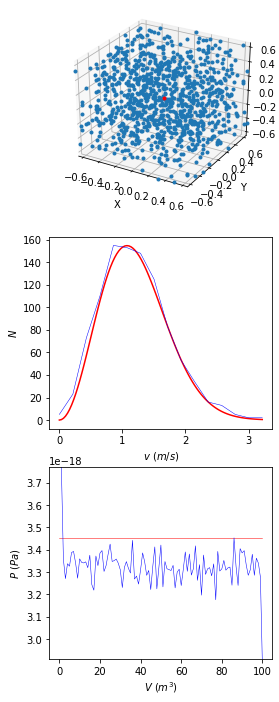

In [4]:
num_parts = 1000
mass = 1.2e-20
radius = 0.01
temp = 500
V0, Vf = 0.5, 15
sim_time = 100

ani = Simulation(num_parts, mass, radius, temp, 2, sim_time, 0.1)
ani.save('constant_V.mp4', fps=30)
plt.show()
ani.save_data()

The experimental velocity distribution agrees well with theory.  The average pressure distribution, however, appears to be lower than the expected constant value. 

-------------------
1000 1.2e-20 0.01 500 <function <lambda> at 0x7f8dfb1f90d0> 100 0.1
-------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: UserWarning: Attempting to set identical bottom == top == 1.3505538378050931e-17 results in singular transformations; automatically expanding.


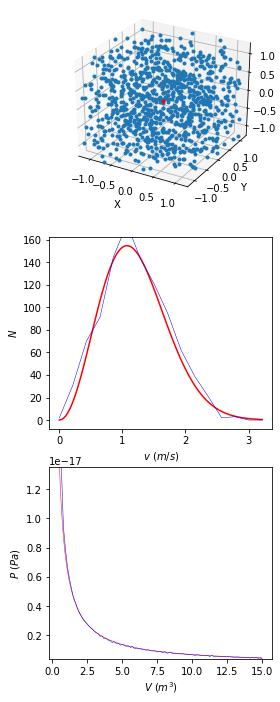

In [5]:
def V(t, V0, Vf, t_max):
    return V0 + (Vf - V0) * t / t_max

num_parts = 1000
mass = 1.2e-20
radius = 0.01
temp = 500
V0, Vf = 0.5, 15
sim_time = 100

ani = Simulation(num_parts, mass, radius, temp, lambda t: V(t, V0, Vf, sim_time), sim_time, 0.1)
ani.save('expanding_V.mp4', fps=30)
plt.show()
ani.save_data()

Both the pressure and velocity distributions compare well to the theory.